In [1]:
import os
import gc
import json
import glob
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import seaborn as sns
import tqdm

import torchvision
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms

import PIL
from PIL import Image, ImageDraw
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from recognition.common import abc, is_valid_str, convert_to_eng
from os import walk
from IPython.display import clear_output
from torchvision import transforms
import random
import torchvision.transforms.functional as TF

In [48]:
def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)

def four_point_transform(image, pts):
    
    rect = order_points(pts)
    
    tl, tr, br, bl = pts
    
    width_1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_2 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_1), int(width_2))
    
    height_1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_1), int(height_2))
    
    dst = np.array([
        [0, 0],
        [max_width, 0],
        [max_width, max_height],
        [0, max_height]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    return warped

def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

class Resize(object):
    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, img):

        w_from, h_from = img.shape[1], img.shape[0]
        w_to, h_to = self.size
        
        # Сделаем разную интерполяцию при увеличении и уменьшении
        # Если увеличиваем картинку, меняем интерполяцию
        interpolation = cv2.INTER_AREA
        if w_to > w_from:
            interpolation = cv2.INTER_CUBIC
        
        img = cv2.resize(img, dsize=self.size, interpolation=interpolation)
        return img
    
def show_image(image, figsize=(8, 4), reverse=False):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()    

In [200]:
OUT_PATH = '/home/mikhailo/dev/python/made/cv-2020/hw/hw2/bl2/lplates'
OUT_GEN_PATH = '/home/mikhailo/dev/python/made/cv-2020/hw/hw2/bl2/lplates_generated'
DATA_PATH = '/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/'

In [35]:
all_marks = load_json(os.path.join(DATA_PATH, 'train.json'))

In [37]:
resize = Resize()
for i, elem in tqdm.tqdm(enumerate(all_marks), leave=False, position=0, total=len(all_marks)):
    img_path = os.path.join(DATA_PATH, elem['file'])
    img = cv2.imread(img_path)
    if img is None:
        continue
    for j, true_box in enumerate(elem['nums']):
        text = true_box['text']
        text = convert_to_eng(text.upper())  # samples can have russian characters or lower case
        if not is_valid_str(text):
            print("Invalid text", text)
            continue            
        crop_name = os.path.join(OUT_PATH, text + ".jpg")

        box = true_box['box']
#         print(text, box, crop_name)
        crop = resize(four_point_transform(img, np.asarray(box)))
#         print(crop.shape)
        cv2.imwrite(crop_name, crop)
#     if i > 100:
#         break
       


/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k н851ху113.png
(50, 235, 3)


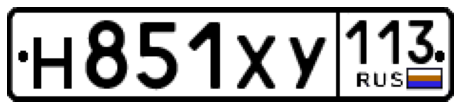

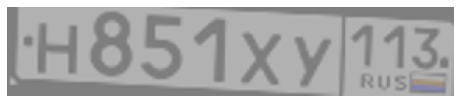

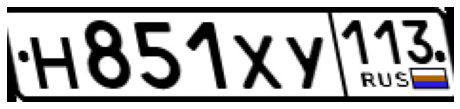

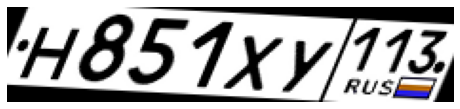

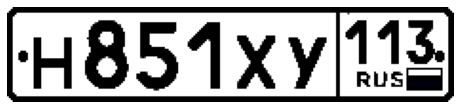

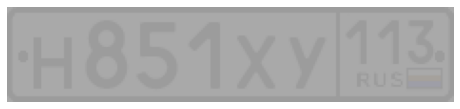

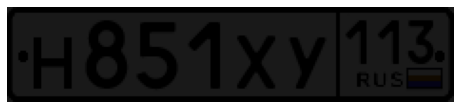

In [236]:
def random_transform(img, h=64, w=320):
    pil_img = transforms.functional.to_pil_image(img)
    pil_img = TF.resize(pil_img, (h, w), PIL.Image.BICUBIC)
    if random.random() > 0.2:
        angle = random.randint(-3, 3)
        translate = random.randint(-5, 5)
        shear = 0
        if random.random() > 0.5:
            shear = random.randint(-20, 20)
        pil_img = TF.affine(
            pil_img, 
            angle, 
            (translate, 0), # translate
            1., # scale
            (shear, 0),
            PIL.Image.BICUBIC
        )
    r = random.random() 
    if random.random() > 0.6:
        pil_img = TF.adjust_contrast(pil_img, 0.05 + r * 0.2)
    else:
        if random.random() > 0.6:
            pil_img = TF.adjust_brightness(pil_img, 0.1 + r * 0.2)
    if random.random() > 0.7:
        k = random.randint(2, 4)
        pil_img = TF.resize(pil_img, (h//k, w//k), PIL.Image.NEAREST)
        pil_img = TF.resize(pil_img, (h, w), PIL.Image.BICUBIC)
    return pil_img

i = 0
for (dirpath, dirnames, filenames) in walk(os.path.join(DATA_PATH, 'generated_60k')):
    for file in filenames:
        print(dirpath, file)
        img_path = os.path.join(dirpath, file)
        img = cv2.imread(img_path)
        print(img.shape)
        h, w,_ = img.shape
        show_image(img)
        show_image(random_transform(img))
        pil_img = transforms.functional.to_pil_image(img)
        show_image(transforms.functional.perspective(
            pil_img, 
            startpoints = [[5,0],[w - 5, 0], [5, h], [w - 5, h]], 
            endpoints = [[0, 0], [w - 10, 0], [10, h], [w, h]], 
            interpolation=3))
        show_image(transforms.functional.affine(
            pil_img, 
            3, 
            (0, 0), # translate
            1., # scale
            (20, 0),
            PIL.Image.BICUBIC
        ))
        show_image(transforms.functional.adjust_gamma(pil_img, 20))
        show_image(transforms.functional.adjust_contrast(pil_img, 0.05))
        show_image(transforms.functional.adjust_brightness(pil_img, 0.1))
        
#         show_image()
        i += 1
        if i > 0:
            break

In [240]:
i = 0
for (dirpath, dirnames, filenames) in walk(os.path.join(DATA_PATH, 'generated_60k')):
    for i, file in tqdm.tqdm(enumerate(filenames), leave=False, position=0, total=len(filenames)):
        img_path = os.path.join(dirpath, file)
        img = cv2.imread(img_path)
        if img is None:
            print(img_path)
            continue
        img = random_transform(img)
        
        text, ext = os.path.splitext(file)
        text = convert_to_eng(text.upper())  # samples can have russian characters or lower case
        if not is_valid_str(text):
            print("Invalid text", text)
            continue
        crop_name = os.path.join(OUT_GEN_PATH, text + ".jpg")
#         print(crop_name)
        img.save(crop_name)
#         if i > 100:
#             break

  0%|          | 136/59987 [00:00<02:59, 333.39it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н276сх147.png


  0%|          | 235/59987 [00:00<03:02, 326.81it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у720нв32.png


  1%|          | 367/59987 [00:01<03:04, 322.47it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к754рм116.png


  1%|▏         | 827/59987 [00:02<02:50, 347.07it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о770ет38.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н618ву70.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в360кв199.png


  2%|▏         | 1177/59987 [00:03<03:00, 325.32it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р976рс116.png


  2%|▏         | 1427/59987 [00:04<02:49, 345.80it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р848тн159.png


  3%|▎         | 1861/59987 [00:05<02:42, 358.31it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к439кн78.png


  3%|▎         | 1967/59987 [00:05<02:50, 340.46it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т441хм763.png


  3%|▎         | 2070/59987 [00:06<02:57, 326.57it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/м049хр38.png


  4%|▎         | 2205/59987 [00:06<02:55, 329.16it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т601во62.png


  4%|▍         | 2414/59987 [00:07<02:46, 344.85it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у258му78.png


  5%|▍         | 2734/59987 [00:08<02:55, 326.75it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к226ру68.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т070ус01.png


  5%|▍         | 2972/59987 [00:08<02:52, 329.74it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е204аа40.png


  5%|▌         | 3039/59987 [00:09<02:55, 324.48it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н894ус147.png


  5%|▌         | 3250/59987 [00:09<02:47, 338.60it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к241ор35.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а635мн186.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/м755ес45.png


  6%|▌         | 3667/59987 [00:10<02:45, 339.59it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у719ум67.png


  7%|▋         | 4047/59987 [00:12<02:42, 343.31it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с764тк67.png


  7%|▋         | 4188/59987 [00:12<02:45, 337.06it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с917ок03.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о818вм68.png


  7%|▋         | 4327/59987 [00:12<02:44, 339.21it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а290ув07.png


  7%|▋         | 4430/59987 [00:13<02:44, 338.27it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а833нр126.png


  8%|▊         | 4846/59987 [00:14<02:46, 330.76it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к398ер16.png


  8%|▊         | 4954/59987 [00:14<02:39, 345.26it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т695хн44.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в651не94.png


  9%|▉         | 5452/59987 [00:16<02:46, 327.27it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а583ст27.png


  9%|▉         | 5556/59987 [00:16<02:42, 335.39it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с716он43.png


 10%|▉         | 5729/59987 [00:17<02:53, 312.30it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в433еа95.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р314ех11.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в685са93.png


 10%|▉         | 5862/59987 [00:17<02:46, 324.39it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у417тн67.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у762сн41.png


 10%|█         | 6038/59987 [00:18<02:38, 339.31it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в155тк14.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е431рк33.png


 11%|█         | 6541/59987 [00:19<02:32, 349.77it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о621хв70.png


 11%|█         | 6646/59987 [00:19<02:42, 328.75it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с094хс199.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е896ес26.png


 12%|█▏        | 6913/59987 [00:20<02:48, 314.59it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в121ак716.png


 12%|█▏        | 7017/59987 [00:20<02:40, 330.62it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е712ме47.png


 12%|█▏        | 7256/59987 [00:21<02:36, 336.18it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р822мм40.png


 13%|█▎        | 7634/59987 [00:22<02:30, 347.08it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к571ах99.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н347ам84.png


 13%|█▎        | 7738/59987 [00:23<02:36, 333.85it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в401ха05.png


 13%|█▎        | 7807/59987 [00:23<02:35, 335.56it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/м602ху22.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в004хт113.png


 13%|█▎        | 8025/59987 [00:23<02:26, 354.84it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р861ск14.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с092са134.png


 14%|█▎        | 8211/59987 [00:24<02:23, 360.76it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т856ун20.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х542км55.png


 14%|█▍        | 8285/59987 [00:24<02:26, 353.42it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р906оу15.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у980но49.png


 14%|█▍        | 8639/59987 [00:25<02:29, 343.85it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х113вм68.png


 15%|█▍        | 8783/59987 [00:26<02:36, 326.22it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н201ун138.png


 15%|█▍        | 8855/59987 [00:26<02:30, 339.23it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х997уо29.png


 15%|█▌        | 9095/59987 [00:27<02:45, 306.80it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о564ср164.png


 15%|█▌        | 9296/59987 [00:27<02:33, 330.92it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к111рх85.png


 16%|█▌        | 9364/59987 [00:28<02:44, 307.17it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к731ве190.png


 16%|█▌        | 9427/59987 [00:28<02:47, 301.84it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х535ас96.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т336рн190.png


 16%|█▌        | 9670/59987 [00:28<02:26, 344.19it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е331уу163.png


 17%|█▋        | 9922/59987 [00:29<02:23, 349.29it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а895ан08.png


 17%|█▋        | 10031/59987 [00:29<02:23, 348.50it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н120оо138.png


 17%|█▋        | 10312/59987 [00:30<02:22, 349.26it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у466ум763.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р826вс90.png


 17%|█▋        | 10383/59987 [00:31<02:26, 338.66it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о981вн19.png


 17%|█▋        | 10452/59987 [00:31<02:28, 334.60it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р788еа150.png


 18%|█▊        | 10664/59987 [00:31<02:22, 346.92it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а365ао30.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е823св84.png


 18%|█▊        | 10737/59987 [00:32<02:22, 345.67it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с460ме08.png


 18%|█▊        | 10847/59987 [00:32<02:22, 343.74it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х071ух59.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в082км123.png


 19%|█▊        | 11241/59987 [00:33<02:20, 348.01it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х921ур34.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в849ка83.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с397тт159.png


 19%|█▉        | 11380/59987 [00:33<02:26, 331.27it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у540вк136.png


 19%|█▉        | 11483/59987 [00:34<02:25, 333.41it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о227вх02.png


 20%|██        | 12140/59987 [00:36<02:29, 320.29it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о666см142.png


 21%|██        | 12518/59987 [00:37<02:19, 339.19it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р134ут43.png


 21%|██        | 12627/59987 [00:37<02:14, 350.96it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р627хк97.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/м765рр19.png


 22%|██▏       | 13456/59987 [00:40<02:18, 336.94it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а640еу96.png


 23%|██▎       | 13698/59987 [00:40<02:17, 335.98it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к420мс57.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с928еа161.png


 23%|██▎       | 13799/59987 [00:41<02:20, 328.85it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с955су136.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в760ка92.png


 24%|██▍       | 14434/59987 [00:43<02:13, 340.97it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о246ку77.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х801ом43.png


 24%|██▍       | 14610/59987 [00:43<02:10, 348.13it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к217он35.png


 25%|██▍       | 14826/59987 [00:44<02:09, 348.92it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у167ен750.png


 25%|██▌       | 15043/59987 [00:44<02:05, 357.38it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н708ук89.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/м922кн08.png


 25%|██▌       | 15149/59987 [00:45<02:14, 334.00it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н900вм74.png


 25%|██▌       | 15252/59987 [00:45<02:13, 334.43it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а588рс116.png


 26%|██▌       | 15487/59987 [00:46<02:22, 311.37it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в654нк173.png


 26%|██▌       | 15555/59987 [00:46<02:17, 322.24it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а326рм09.png


 26%|██▌       | 15690/59987 [00:46<02:20, 315.90it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х428ум77.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/м818от02.png


 26%|██▋       | 15799/59987 [00:47<02:09, 340.08it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а447ка47.png


 27%|██▋       | 16039/59987 [00:47<02:17, 320.27it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р127ен67.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х159ук36.png


 27%|██▋       | 16179/59987 [00:48<02:09, 338.18it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т319ан777.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в175ма02.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у372рв60.png


 28%|██▊       | 16598/59987 [00:49<02:04, 347.28it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к643ер47.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у544мт06.png


 28%|██▊       | 16670/59987 [00:49<02:04, 348.04it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р359кс05.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/м204вр77.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у693ан75.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н409мо06.png


 28%|██▊       | 16847/59987 [00:50<02:05, 344.49it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а712ха196.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т113ум33.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т414ао173.png


 29%|██▊       | 17122/59987 [00:51<02:07, 336.81it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р425ус763.png


 29%|██▊       | 17190/59987 [00:51<02:10, 328.44it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у362мв61.png


 29%|██▉       | 17607/59987 [00:52<02:01, 347.44it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р418ке138.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у669тк52.png


 30%|███       | 18066/59987 [00:53<02:02, 341.06it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с299рх09.png


 30%|███       | 18170/59987 [00:54<02:04, 335.27it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т821ха68.png


 31%|███       | 18374/59987 [00:54<02:09, 322.48it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у699тв65.png


 31%|███▏      | 18786/59987 [00:56<02:06, 325.22it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у383вв29.png


 31%|███▏      | 18891/59987 [00:56<02:03, 333.23it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р831тх15.png


 32%|███▏      | 19105/59987 [00:57<02:00, 338.77it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к172ах49.png


 32%|███▏      | 19347/59987 [00:57<02:02, 331.92it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/м460тв45.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с682ав86.png


 32%|███▏      | 19487/59987 [00:58<01:59, 338.20it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е764су06.png


 33%|███▎      | 19659/59987 [00:58<01:58, 341.00it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а178ве93.png


 34%|███▍      | 20623/59987 [01:01<01:54, 343.01it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к673ео29.png


 35%|███▍      | 20728/59987 [01:01<01:55, 341.12it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у409ем01.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е949ох64.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т124вв90.png


 35%|███▍      | 20871/59987 [01:02<02:00, 325.61it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с435нм60.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у197ку57.png


 35%|███▌      | 21144/59987 [01:03<01:58, 327.79it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к556ав56.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р157сх95.png


 36%|███▌      | 21484/59987 [01:04<02:00, 319.23it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у271тн163.png


 36%|███▌      | 21652/59987 [01:04<02:00, 318.82it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в567ао52.png


 36%|███▋      | 21819/59987 [01:05<02:04, 307.33it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с667ср10.png


 37%|███▋      | 22093/59987 [01:06<01:53, 333.15it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н042кс41.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в477ру58.png


 37%|███▋      | 22268/59987 [01:06<01:53, 331.59it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р668ар147.png


 37%|███▋      | 22337/59987 [01:06<01:51, 336.73it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х948нт74.png


 38%|███▊      | 22646/59987 [01:07<01:49, 342.20it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т085ху08.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е428тр82.png


 38%|███▊      | 22819/59987 [01:08<01:57, 316.15it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н169уо35.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р980ве10.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е112ух116.png


 38%|███▊      | 23034/59987 [01:09<01:49, 337.85it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о760хм71.png


 39%|███▊      | 23216/59987 [01:09<01:46, 344.86it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в440ек04.png


 39%|███▉      | 23460/59987 [01:10<01:49, 334.50it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у942рс142.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у785хт18.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с359кх57.png


 39%|███▉      | 23528/59987 [01:10<01:48, 336.21it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о995мв716.png


 40%|███▉      | 23699/59987 [01:11<01:48, 334.64it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т077са777.png


 40%|███▉      | 23802/59987 [01:11<01:48, 335.01it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о848нн142.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н506ам196.png


 40%|███▉      | 23909/59987 [01:11<01:45, 343.50it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т262ам26.png


 40%|████      | 24151/59987 [01:12<01:51, 322.17it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/м182еу35.png


 40%|████      | 24256/59987 [01:12<01:47, 331.72it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с291са71.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о419рх53.png


 41%|████      | 24502/59987 [01:13<01:43, 344.16it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у432ук82.png


 41%|████      | 24643/59987 [01:13<01:43, 342.22it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к531нв14.png


 41%|████      | 24713/59987 [01:14<01:43, 340.39it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а971во28.png


 42%|████▏     | 24957/59987 [01:14<01:42, 341.33it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н699ек31.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х691то50.png


 42%|████▏     | 25101/59987 [01:15<01:39, 350.64it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в935то777.png


 42%|████▏     | 25207/59987 [01:15<01:42, 338.61it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/м702мн90.png


 42%|████▏     | 25492/59987 [01:16<01:39, 347.30it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в262еа62.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н450от18.png


 43%|████▎     | 25704/59987 [01:16<01:38, 346.33it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т536кс63.png


 43%|████▎     | 25810/59987 [01:17<01:40, 339.23it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у013тр35.png


 44%|████▎     | 26239/59987 [01:18<01:43, 326.51it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р912ус68.png


 44%|████▍     | 26305/59987 [01:18<01:44, 321.01it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р941хк22.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к096тх97.png


 44%|████▍     | 26522/59987 [01:19<01:37, 343.73it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р236сх10.png


 45%|████▍     | 26903/59987 [01:20<01:36, 341.95it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/м319хв80.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в998нк81.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н288ус08.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р347вт46.png


 45%|████▌     | 27256/59987 [01:21<01:36, 337.62it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у036ка94.png


 47%|████▋     | 27986/59987 [01:23<01:36, 332.63it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р793ко05.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у389св99.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н926вт18.png


 48%|████▊     | 28818/59987 [01:26<01:42, 304.35it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е954ст36.png


 48%|████▊     | 29061/59987 [01:27<01:51, 276.28it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т739ме81.png


 49%|████▉     | 29412/59987 [01:28<01:50, 276.94it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т689та90.png


 49%|████▉     | 29632/59987 [01:29<01:43, 293.32it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к339ор13.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в039ме81.png


 50%|████▉     | 29721/59987 [01:29<01:46, 283.46it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а710ук48.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о114оу90.png


 50%|████▉     | 29842/59987 [01:30<01:46, 283.79it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в966на22.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о338ар23.png


 50%|████▉     | 29938/59987 [01:30<01:39, 303.19it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х942ав13.png


 50%|█████     | 30153/59987 [01:31<01:41, 295.35it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е989ку17.png


 51%|█████     | 30364/59987 [01:32<01:43, 284.84it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о036ну33.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х120ва125.png


 51%|█████     | 30540/59987 [01:32<01:35, 308.60it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с449кт92.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/м310рм32.png


 52%|█████▏    | 31066/59987 [01:34<01:25, 337.41it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а289та01.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в297нк72.png


 52%|█████▏    | 31279/59987 [01:34<01:21, 350.21it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в612кх09.png


 52%|█████▏    | 31490/59987 [01:35<01:22, 347.23it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о620ао57.png


 53%|█████▎    | 31560/59987 [01:35<01:25, 333.80it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х049вн07.png


 53%|█████▎    | 31697/59987 [01:36<01:26, 327.28it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о606хе31.png


 53%|█████▎    | 31967/59987 [01:37<01:26, 325.35it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у864ак62.png


 54%|█████▎    | 32241/59987 [01:37<01:34, 293.32it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е517тм82.png


 54%|█████▍    | 32303/59987 [01:38<01:32, 299.13it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т270вх24.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к900уо14.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н521ех163.png


 55%|█████▍    | 32703/59987 [01:39<01:20, 337.32it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т453сн199.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е624оу56.png


 55%|█████▍    | 32983/59987 [01:40<01:20, 333.40it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к741ас09.png


 55%|█████▌    | 33262/59987 [01:40<01:20, 330.12it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с726ос36.png


 56%|█████▌    | 33496/59987 [01:41<01:21, 324.48it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р872ср54.png


 56%|█████▌    | 33569/59987 [01:41<01:17, 341.39it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а814рв77.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с855но22.png


 56%|█████▋    | 33789/59987 [01:42<01:14, 350.83it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у271ое53.png


 57%|█████▋    | 34359/59987 [01:44<01:14, 342.72it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к819ев199.png


 58%|█████▊    | 34745/59987 [01:45<01:14, 340.70it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о474кс102.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с381рн92.png


 59%|█████▊    | 35205/59987 [01:46<01:13, 338.22it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с870ах99.png


 59%|█████▉    | 35350/59987 [01:47<01:10, 349.79it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у848ту75.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с404вв136.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а219ва46.png


 59%|█████▉    | 35596/59987 [01:47<01:12, 335.81it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о411рм763.png


 60%|█████▉    | 35732/59987 [01:48<01:15, 319.56it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р727уо126.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х025уо45.png


 60%|█████▉    | 35832/59987 [01:48<01:17, 310.81it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у643ре69.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у123ев07.png


 60%|██████    | 36111/59987 [01:49<01:08, 346.83it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х328ро88.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х783хт102.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с329ак71.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х597ау10.png


 62%|██████▏   | 36894/59987 [01:51<01:05, 353.53it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а104еа32.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е153нх33.png


 62%|██████▏   | 37073/59987 [01:52<01:05, 350.48it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к309вс125.png


 63%|██████▎   | 37516/59987 [01:53<01:10, 316.69it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а813ко62.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н903см43.png


 63%|██████▎   | 37764/59987 [01:54<01:02, 353.33it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в411ос16.png


 63%|██████▎   | 37988/59987 [01:55<01:01, 358.15it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х143он45.png


 64%|██████▎   | 38164/59987 [01:55<01:05, 334.74it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а255ое186.png


 64%|██████▍   | 38376/59987 [01:56<01:03, 343.01it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с476мк12.png


 64%|██████▍   | 38615/59987 [01:56<01:06, 323.64it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а008вт150.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х553ук18.png


 65%|██████▌   | 39125/59987 [01:58<01:03, 329.17it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т137мн55.png


 65%|██████▌   | 39227/59987 [01:58<01:02, 333.54it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с637уе116.png


 67%|██████▋   | 39961/59987 [02:01<00:59, 338.97it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к375со60.png


 67%|██████▋   | 40030/59987 [02:01<00:59, 338.06it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с606ов89.png


 67%|██████▋   | 40170/59987 [02:01<00:58, 341.55it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/м753ка61.png


 68%|██████▊   | 40579/59987 [02:02<00:57, 334.80it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к182тн88.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с536ун19.png


 68%|██████▊   | 40900/59987 [02:03<00:56, 340.39it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а045еа56.png


 68%|██████▊   | 41005/59987 [02:04<00:55, 344.56it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к077ск24.png


 69%|██████▊   | 41142/59987 [02:04<00:57, 329.32it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о813рт173.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н780нв27.png


 69%|██████▉   | 41314/59987 [02:05<00:56, 331.99it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/м343кк86.png


 69%|██████▉   | 41481/59987 [02:05<00:58, 316.04it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н268ар38.png


 69%|██████▉   | 41677/59987 [02:06<00:57, 320.12it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о984не121.png


 70%|██████▉   | 41810/59987 [02:06<00:56, 320.10it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/м382рт45.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в851ов58.png


 70%|██████▉   | 41915/59987 [02:07<00:53, 339.00it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о525мт87.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с099вр61.png


 70%|███████   | 42021/59987 [02:07<00:52, 344.55it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в492от92.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в854ув75.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е495нм93.png


 70%|███████   | 42123/59987 [02:07<00:55, 324.60it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н343ев102.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е456нс41.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р310хк46.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т865вм03.png


 70%|███████   | 42264/59987 [02:08<00:51, 342.34it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а517уе15.png


 71%|███████   | 42400/59987 [02:08<00:53, 327.16it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х762мм86.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н808хе33.png


 71%|███████   | 42536/59987 [02:08<00:55, 313.27it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о185ек54.png


 71%|███████   | 42670/59987 [02:09<00:53, 322.26it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к073вн71.png


 71%|███████▏  | 42772/59987 [02:09<00:52, 325.10it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/м940ву73.png


 71%|███████▏  | 42875/59987 [02:09<00:51, 333.44it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с294тв94.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с632тс38.png


 72%|███████▏  | 43009/59987 [02:10<00:53, 319.89it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т713тв66.png


 72%|███████▏  | 43174/59987 [02:10<00:54, 310.62it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а576хс19.png


 72%|███████▏  | 43409/59987 [02:11<00:50, 330.35it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н715ух34.png


 73%|███████▎  | 43591/59987 [02:12<00:45, 358.54it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т345вт12.png


 73%|███████▎  | 43664/59987 [02:12<00:45, 355.66it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а593ну99.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е470вт147.png


 74%|███████▍  | 44315/59987 [02:14<00:45, 342.37it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р362рк28.png


 74%|███████▍  | 44426/59987 [02:14<00:43, 354.84it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х756ув196.png


 75%|███████▍  | 44753/59987 [02:15<00:44, 340.53it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с903ха99.png


 75%|███████▍  | 44896/59987 [02:15<00:43, 346.60it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р327нт64.png


 75%|███████▌  | 45003/59987 [02:16<00:45, 327.51it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с821вх27.png


 75%|███████▌  | 45147/59987 [02:16<00:42, 351.58it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с550то163.png


 75%|███████▌  | 45255/59987 [02:17<00:42, 344.52it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т556оу38.png


 76%|███████▌  | 45362/59987 [02:17<00:45, 324.14it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н389тс73.png


 77%|███████▋  | 45925/59987 [02:19<00:41, 335.24it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о314ас08.png


 77%|███████▋  | 45996/59987 [02:19<00:41, 340.27it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о014хк147.png


 78%|███████▊  | 46711/59987 [02:21<00:40, 328.27it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р179рм13.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с773мн154.png


 78%|███████▊  | 47019/59987 [02:22<00:38, 333.98it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х032нс41.png


 79%|███████▉  | 47427/59987 [02:23<00:37, 332.88it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р165ке60.png


 79%|███████▉  | 47534/59987 [02:23<00:36, 341.32it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/м207ук34.png


 80%|███████▉  | 47894/59987 [02:24<00:34, 347.07it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с545са70.png


 80%|████████  | 48175/59987 [02:25<00:34, 346.92it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к904су92.png


 81%|████████  | 48345/59987 [02:26<00:36, 314.73it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к510он53.png


 81%|████████  | 48487/59987 [02:26<00:33, 338.93it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х872нк06.png


 81%|████████  | 48558/59987 [02:26<00:33, 345.13it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е721мт89.png


 82%|████████▏ | 48913/59987 [02:27<00:32, 337.14it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у144ма54.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о717мх35.png


 82%|████████▏ | 49190/59987 [02:28<00:31, 341.42it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т289ау13.png


 83%|████████▎ | 49701/59987 [02:30<00:29, 343.24it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а663ха29.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е766аа38.png


 83%|████████▎ | 49842/59987 [02:30<00:29, 343.66it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а620тм134.png


 84%|████████▎ | 50144/59987 [02:31<00:30, 321.17it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о496ер88.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а521мс13.png


 84%|████████▍ | 50281/59987 [02:32<00:28, 337.59it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/м710хм57.png


 84%|████████▍ | 50457/59987 [02:32<00:28, 335.11it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в009уа04.png


 84%|████████▍ | 50526/59987 [02:32<00:28, 337.61it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/м179мк750.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/м369ов07.png


 85%|████████▍ | 50773/59987 [02:33<00:26, 341.77it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о486нр22.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р518от80.png


 85%|████████▍ | 50987/59987 [02:34<00:28, 318.60it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н051ва152.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а824еу72.png


 85%|████████▌ | 51193/59987 [02:34<00:25, 339.23it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с208то24.png


 86%|████████▌ | 51553/59987 [02:35<00:24, 342.36it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у582тс06.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е017ук09.png


 86%|████████▌ | 51728/59987 [02:36<00:25, 321.84it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х043ем15.png


 87%|████████▋ | 52396/59987 [02:38<00:22, 330.21it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т724ув08.png


 88%|████████▊ | 52502/59987 [02:38<00:21, 343.19it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х003он51.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н959ух50.png


 88%|████████▊ | 52789/59987 [02:39<00:21, 335.14it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у878еа04.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р033ам07.png


 88%|████████▊ | 52896/59987 [02:39<00:20, 344.87it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а566еа101.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н600св147.png


 89%|████████▊ | 53111/59987 [02:40<00:19, 350.56it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в358нс75.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/м327нт70.png


 89%|████████▉ | 53564/59987 [02:41<00:19, 337.64it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о074оу13.png


 90%|████████▉ | 53703/59987 [02:42<00:18, 338.31it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р812ра15.png


 90%|████████▉ | 53916/59987 [02:42<00:17, 342.23it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т490ев08.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/м667кр58.png


 90%|████████▉ | 53985/59987 [02:43<00:17, 337.04it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е602уа57.png


 91%|█████████▏| 54790/59987 [02:45<00:15, 336.72it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т970мв11.png


 92%|█████████▏| 54893/59987 [02:45<00:15, 336.05it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е470хс66.png


 92%|█████████▏| 55099/59987 [02:46<00:14, 328.76it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в159ае138.png


 92%|█████████▏| 55269/59987 [02:46<00:14, 333.50it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/в586уу46.png


 92%|█████████▏| 55475/59987 [02:47<00:13, 325.93it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р306ум74.png


 93%|█████████▎| 55681/59987 [02:48<00:12, 336.07it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н060уу84.png


 93%|█████████▎| 55918/59987 [02:48<00:12, 327.57it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т585хх30.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с916хх35.png


 93%|█████████▎| 56081/59987 [02:49<00:12, 310.38it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х984ет46.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е129ру81.png


 94%|█████████▍| 56249/59987 [02:49<00:11, 315.16it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к793со134.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к388кр125.png


 94%|█████████▍| 56319/59987 [02:50<00:11, 330.83it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/м215се10.png


 94%|█████████▍| 56530/59987 [02:50<00:10, 342.39it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к045ру41.png


 94%|█████████▍| 56635/59987 [02:51<00:10, 319.87it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к508ус06.png


 95%|█████████▍| 56812/59987 [02:51<00:09, 337.35it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е649хв70.png


 95%|█████████▍| 56915/59987 [02:51<00:09, 329.17it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/т085тн16.png


 95%|█████████▌| 57046/59987 [02:52<00:09, 309.17it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/е036та25.png


 95%|█████████▌| 57215/59987 [02:52<00:08, 325.63it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/с186вв68.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/х761ве69.png


 96%|█████████▌| 57354/59987 [02:53<00:07, 335.74it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/у598те14.png


 96%|█████████▌| 57493/59987 [02:53<00:07, 340.67it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а474сх64.png


 96%|█████████▌| 57564/59987 [02:53<00:07, 344.95it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о441ун16.png


 97%|█████████▋| 58126/59987 [02:55<00:05, 341.40it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/к259рр05.png


 97%|█████████▋| 58301/59987 [02:56<00:05, 303.51it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/а408хв99.png
/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р138рх07.png


 97%|█████████▋| 58368/59987 [02:56<00:05, 315.27it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н825ав76.png


 98%|█████████▊| 58794/59987 [02:57<00:03, 349.53it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/н230ае85.png


 98%|█████████▊| 58937/59987 [02:58<00:03, 344.13it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/о547нм87.png


100%|█████████▉| 59700/59987 [03:00<00:00, 324.52it/s]

/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/generated_60k/р452хе36.png


In [2]:
import torchvision.models as models

In [11]:
resnet = models.resnet34()
cnn = nn.Sequential(*list(resnet.children())[:-2])

In [13]:
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [16]:
cnn[-1][-1].bn2.num_features

512

In [ ]:
import numpy as np
import torch
from torch import nn
from torchvision import models
from .common import abc


class RecognitionModel(nn.Module):
    def __init__(self, dropout=0.3, num_directions=1):
        # see workshop #9 for more details
        # (https://github.com/BorisLestsov/MADE/blob/master/seminar9-carocr/9%20-%20crnn%20-%20completed.ipynb)
        super(RecognitionModel, self).__init__()
        self.abc = abc
        self.num_classes = len(self.abc)
        self.num_directions = num_directions

        resnet = getattr(models, 'resnet50')(pretrained=True) # TODO: is it most optimal choice ?
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])

        self.proj = nn.Conv2d(10, 24, kernel_size=1)
        # TODO: move these parameters to the constructor function in order experiment using factories & configs
        # TODO: try other RNNs or even CNNs, if you've got enough time
        self.rnn = nn.GRU(input_size=512,
                          hidden_size=128,
                          num_layers=2,
                          batch_first=False,
                          dropout=dropout,
                          bidirectional=(num_directions == 2))

        self.linear = nn.Linear(128 * num_directions, len(abc)+1, bias=False)
        self.softmax = nn.Softmax(dim=2)
        
    def init_hidden(self, batch_size, device):
        hidden = torch.zeros(self.rnn.num_layers * self.num_directions,
                             batch_size,
                             self.rnn.hidden_size)
        hidden = hidden.to(device)
        return hidden

    def forward(self, x, decode=False):
        hidden = self.init_hidden(x.size(0), next(self.parameters()).device)
        features = self.cnn(x)
        sequence = self.features_to_sequence(features)
        sequence, hidden = self.rnn(sequence, hidden)
        sequence = self.linear(sequence)

        if not self.training:
            sequence = self.softmax(sequence)
            if decode:
                sequence = self.decode(sequence)

        return sequence

    def features_to_sequence(self, features):
        b, c, h, w = features.size()
        assert h == 1, '1 != {}'.format(h)
        features = features.permute(0, 3, 2, 1).contiguous()
        features = self.proj(features)
        features = features.permute(1, 0, 2, 3).contiguous()
        features = features.squeeze(2)
        return features

    def get_block_size(self, layer):
        return layer[-1][-1].bn2.weight.size()[0]

    def pred_to_string(self, pred):
        seq = []
        for i in range(len(pred)):
            label = np.argmax(pred[i])
            seq.append(label - 1)
        out = []
        for i in range(len(seq)):
            if len(out) == 0:
                if seq[i] != -1:
                    out.append(seq[i])
            else:
                if seq[i] != -1 and seq[i] != seq[i - 1]:
                    out.append(seq[i])
        out = ''.join([self.abc[c] for c in out])
        return out

    def decode(self, pred):
        pred = pred.permute(1, 0, 2).cpu().data.numpy()
        outputs = []
        for i in range(len(pred)):
            outputs.append(self.pred_to_string(pred[i]))
        return outputs
